In [6]:
import gdal, osr
import numpy as np
from skimage.graph import route_through_array
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
import math
from osgeo import ogr
import fiona
import jenkspy

## For working with rasters

The Raster files are converted to numpy array for further processing and calculations. 
Raster Properties are stored in RasterProp class.

In [2]:
def raster2array(rasterfn):
    print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array


class RasterProp:
    def __init__(self,
                 rasterFile,
                 sliceClass=None, slicing = False):
        self.raster = gdal.Open(rasterFile)
        self.geotransform = self.raster.GetGeoTransform()
        self.projRef      = self.raster.GetProjectionRef()
        self.originX = self.geotransform[0]
        self.originY = self.geotransform[3] 
        self.pixelWidth = self.geotransform[1] 
        self.pixelHeight = self.geotransform[5]
        
        if slicing:
            print('recomputing origin')
            x_ori_rel , y_ori_rel, xlen, ylen = sliceClass.relevantArea()
            self.originX, self.originY = pixel2coord(self.geotransform, 
                                                     x_ori_rel, 
                                                     y_ori_rel)
        
def coord2pixelOffset(rasProp,x,y):
    print('coordinate to pixel offsetting...')
    originX = rasProp.originX
    originY = rasProp.originY
    
    pixelWidth = rasProp.pixelWidth 
    pixelHeight = rasProp.pixelHeight

    xOffset = int((x - originX)/pixelWidth)
    yOffset = int((y - originY)/pixelHeight)
    return xOffset,yOffset


def pixel2coord(geoTrans, x, y):
    xoff, a, b, yoff, d, e = geoTrans

    xp = a * x + b * y + a * 0.5 + b * 0.5 + xoff
    yp = d * x + e * y + d * 0.5 + e * 0.5 + yoff
    return(int(xp), int(yp))


def array2raster(array, rasProp,newRasterfn):
    print('converting array to raster...')
    cols = array.shape[1]
    rows = array.shape[0]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create( newRasterfn, 
                              cols, rows,
                              bands=1, 
                              eType= gdal.GDT_Float32)
    outRaster.SetGeoTransform((rasProp.originX, 
                               rasProp.pixelWidth, 
                               0, rasProp.originY, 
                               0, rasProp.pixelHeight))
    
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(rasProp.projRef)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## Slicing

---- under development (not required for)-----

To reduce the size of the array files, a slicing of 'relevant' area would be useful. 

In [9]:
class Slicing:
    '''The class used for slicing the data. Doesn't work for all datasets '''
    def __init__(self, rasProp, strPoint, endPoint):
        self.rasProp  = rasProp
        self.strPoint = strPoint
        self.endPoint = endPoint
        
        self.strPix = coord2pixelOffset(self.rasProp, 
                                   self.strPoint[0], 
                                   self.strPoint[1])
        
        self.endPix = coord2pixelOffset(self.rasProp, 
                                   self.endPoint[0],
                                   self.endPoint[1])
        
    def strLineDistance(self):
        
        return int(math.sqrt((self.strPix[0]-self.endPix[0])**2+
                             ((self.strPix[1]-self.endPix[1])**2)))
    
    
    def xydistance(self):
        x_width = abs(self.strPix[0]-self.endPix[0])
        y_width = abs(self.strPix[1]-self.endPix[1]) 
        return x_width, y_width 
    
    
    def relevantArea(self, xMargin=1.2, yMargin=1.2):
        strDist = self.strLineDistance()
        xWidth , yWidth = self.xydistance()
        #xWidth = xWidth*xMargin
        #yWidth = yWidth*yMargin
        
        x_ori_rel = int(self.strPix[0] - strDist/5)
        y_ori_rel = int(self.strPix[1] - strDist/5)
        
        selAreax_w = int(xWidth+2*strDist/5)
        selAreay_w = int(yWidth+2*strDist/5)
        if x_ori_rel < 0:
            x_ori_rel = 0

        if y_ori_rel < 0:
            y_ori_rel = 0
            
        #if selAreay_w < 0:
        #    y_ori_rel =

        print('relevant area slice:x_ori,x_width,y_orig,y_width', 
              x_ori_rel, selAreax_w, y_ori_rel, selAreay_w)
        
        return x_ori_rel, y_ori_rel, selAreax_w, selAreay_w


def array2raster_slice(array, sliceClass,
                       rasProp, newRasterfn):
    print('converting slice array to raster...')
    cols = array.shape[1]
    rows = array.shape[0]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, 
                              cols, rows, 
                              gdal.gdal.GDT_Float32)
    x_ori_rel , y_ori_rel, xlen, ylen = sliceClass.relevantArea()
    x_origin, y_origin = pixel2coord(rasProp, x_ori_rel, y_ori_rel)
    
    outRaster.SetGeoTransform((x_origin, 
                               rasProp.pixelWidth, 
                               0, y_origin, 
                               0, rasProp.pixelHeight))
    
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(rasProp.projRef)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [11]:
def shapeTestAll(factorPaths):
    for factor in factorPaths:
        print(np.shape(raster2array(factor)))

# Data Preparation

## Jenks Natural Breaks Classification

Jenks Natural breaks classification algorithm is used to classify the **elevation**, **population**, and **slope** data. https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization

This is required because simple normalization would significantly undervalue the data because of extreme peaks. 

The data has been broken into 10 clusters with values mapped between 0 to 10. 

Since jenks classification algorithm is very time consuming, it is not possible to run it on the entire dataset to compute the breaks. Hence, the breaks have been calculted based on a random sample of the original data. The size of the random sample is 100000.

Running this again would create (slightly) different breaks and hence to reproduce the results it is not recommended to the classification again.

In [3]:
elevPathOri = os.path.abspath('01_Data500/elevation.tif')
popuPathOri = os.path.abspath('01_Data500/population.tif')
slopPathOri = os.path.abspath('01_Data500/slope.tif')

In [32]:
def jenks_classify(originalRaster, outRaster, sampleSize=1000):
    array = raster2array(originalRaster)
    print('array created...')
    array[np.isnan(array)]=0
    array_f = array.ravel()
    print('finding breaks...')
    array_sam = np.random.choice(array_f, size=sampleSize, replace=False)
    breaks = jenkspy.jenks_breaks(array_sam, nb_class=9)
    print(breaks)
    print('digitizing...')
    array_f_dig = np.digitize(array_f, breaks).astype(float)
    array_dig = np.reshape(array_f_dig, np.shape(array))
    array2raster(array_dig, RasterProp(originalRaster), outRaster)
    return array_dig

In [33]:
#jenks_classify(elevPathOri, os.path.abspath('01_Data500/elevation_jc.tif'))

converting raster to array...
array created...
finding breaks...
[-6.445716857910156, 54.97124099731445, 173.21983337402344, 320.7486267089844, 515.2106323242188, 732.7840576171875, 970.2399291992188, 1291.229248046875, 1711.7459716796875, 2228.373046875]
digitizing...
converting array to raster...


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [22]:
#jenks_classify(popuPathOri, os.path.abspath('01_Data500/population_jc.tif'))

converting raster to array...
array created...
finding breaks...
[0.0, 7.0, 30.0, 66.0, 103.0, 154.0, 220.0, 334.0, 471.0, 1507.0, 3339.0]
digitizing...
converting array to raster...


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [23]:
#jenks_classify(slopPathOri, os.path.abspath('01_Data500/slope_jc.tif'))

converting raster to array...
array created...
finding breaks...
[0.0, 0.6363528966903687, 1.9423604011535645, 3.4714224338531494, 5.077847957611084, 8.066366195678711, 10.374420166015625, 14.328324317932129, 18.270305633544922, 23.45761489868164, 29.169322967529297]
digitizing...
converting array to raster...


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Calculation of total cost raster

In [38]:
def createTotalCostRaster(factorPathList, 
                          weightList, 
                          rasProp,
                          rasterName, 
                          slicing=False, 
                          strPoint=None, 
                          endPoint=None):
    
    if not slicing:
        #print(factorNames[0])
        costArray = maxMinScale(raster2array(factorPathList[0]))*weightList[0]
        costArray[np.isnan(costArray)]=0
        
        for fpos in range(1,len(factorPathList)):
            #print(factorNames[fpos])
            factorArray = maxMinScale(raster2array(factorPathList[fpos]))*weightList[fpos]
            factorArray[np.isnan(factorArray)]=0
            #plt.imshow(factorArray)
            costArray = np.add(costArray, factorArray)
        costArray[np.isnan(costArray)]=0
        plt.imshow(costArray)
        plt.colorbar()
        array2raster(costArray, rasProp, rasterName)
        return costArray, rasProp
    
    
    else:
        sliceObj = Slicing(rasProp, strPoint, endPoint)
        raster = gdal.Open(factorPathList[0])
        band   = raster.GetRasterBand(1)
        
        x_ori_rel , y_ori_rel, xlen, ylen = sliceObj.relevantArea()
        
        sliceRasProp = RasterProp(factorPathList[0],
                                  slicing   = True, 
                                  sliceClass= sliceObj)
        
        array = band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         )
        
        costArray = maxMinScale(array)*weightList[0]
        
        for fpos in range(1, len(factorPathList)):
            raster = gdal.Open(factorPathList[fpos])
            band   = raster.GetRasterBand(1)
            factorArray = maxMinScale(band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         ))*weightList[fpos]
            
            costArray = np.add(costArray, factorArray)
        
        np.place(costArray, costArray==nan,0)
        array2raster(costArray, sliceRasProp, rasterName)
        plt.imshow(costArray)
        return costArray, sliceRasProp

    

#getStartEndCord(dc1)

In [40]:
def maxMinScale(array):
    return (array/abs(array.max()-array.min()))

In [36]:
corePath = os.path.abspath('01_Data500/corine.tif')
elevPath = os.path.abspath('01_Data500/elevation_jc.tif')
gridPath = os.path.abspath('01_Data500/grid_pos.tif')
popuPath = os.path.abspath('01_Data500/population_jc.tif')
protPath = os.path.abspath('01_Data500/protected.tif')
railPath = os.path.abspath('01_Data500/rails_pos.tif')
rivePath = os.path.abspath('01_Data500/river.tif')
roadPath = os.path.abspath('01_Data500/roads_pos.tif')
slopPath = os.path.abspath('01_Data500/slope_jc.tif')
seaPath  = os.path.abspath('01_Data500/sea.tif')

In [6]:
factorPaths = [
             corePath,
    elevPath,
    gridPath,
    popuPath,
    protPath,
    railPath,
    rivePath,
    roadPath,
    slopPath,
    seaPath
            ]

factorWeights = [
                1,#corine
                1,#elevation
                1,#grid
                1,#population
                1,#protected
                1,#rails
                1,#river
                1,#roads
                1,#slope
                10#deepsea
                ]

factorNames = [
    'Corine',
    'elevation',
    'grid',
    'population',
    'protected',
    'rails',
    'river',
    'roads',
    'slope',
    'sea'
]

# Rasters grouped to four factors of analysis

add description

## Economic Factors

eco factor raster, weigths =0.5, 0.5 because 2 factors

when considering only slope weight = 1.0

converting raster to array...
converting array to raster...


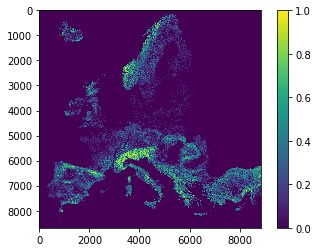

In [41]:
ecoFac = [slopPath]
ecoFacRaster = os.path.abspath('01_Data500/fac_eco_onlySlope.tif')
ecoArray, ecoProp =   createTotalCostRaster(factorPathList=ecoFac, weightList=[1], 
                      rasProp = RasterProp(corePath), rasterName = ecoFacRaster)

## Environmental Factors

env factors rasters, weights =0.33,0.33,0.33 because 3

converting raster to array...
converting raster to array...
converting raster to array...
converting array to raster...


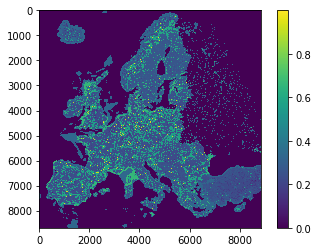

In [42]:
envFac = [corePath, rivePath, protPath]
envFacRaster = os.path.abspath('01_Data500/fac_env.tif')
envArray, envProp =   createTotalCostRaster(factorPathList=envFac, 
                                            weightList=[0.333,0.333,0.333], 
                                            rasProp = RasterProp(corePath), 
                                            rasterName = envFacRaster)

## Population Factor 

converting raster to array...
converting array to raster...


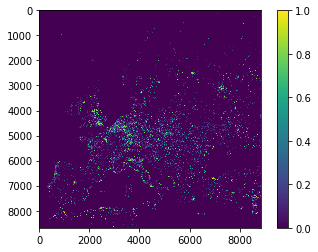

In [43]:
pubFac = [popuPath]
pubFacRaster = os.path.abspath('01_Data500/fac_pub.tif')
pubArray, pubProp =   createTotalCostRaster(factorPathList=pubFac, weightList=[1], 
                    rasProp = RasterProp(popuPath), rasterName = pubFacRaster)

## Infra Factor

converting raster to array...
converting raster to array...
converting raster to array...
converting array to raster...


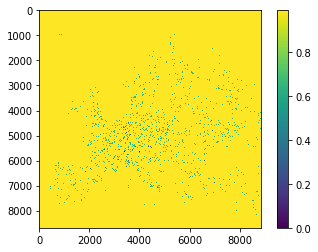

In [44]:
infFac = [gridPath, roadPath, railPath]
infFacRaster = os.path.abspath('01_Data500/fac_inf.tif')
infArray, infProp =   createTotalCostRaster(factorPathList=infFac, 
                                          weightList=[0.33,0.33,0.33], 
                    rasProp = RasterProp(railPath), rasterName = infFacRaster)

## City Area

In [34]:
corOriPath = os.path.abspath('01_Data500/corine_500_original_classification.tif')
cityPath = os.path.abspath('01_Data500/city.tif')


def createCityRaster(cityValue):
    corAre = raster2array(corOriPath)
    cityAr = corAre.copy()
    cityAr[np.isin(corAre, [1,2,3,10,11,7])] =cityValue
    print(cityAr)
    cityAr[np.isin(corAre, [1,2,3,10,11,7], invert=True)]=0
    print(cityAr)
    array2raster(cityAr,RasterProp(corOriPath),cityPath)
    return cityAr

In [19]:
def shapeTest(arrayList):
    for array in arrayList:
        print(np.shape(array))